# "Text mining with chemical text from chemdNER"
> "This is a take home project that I did for a company as part of their interview process."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [take-home, deep-learning, spacy, nlp]
- hide: false

This blog post has the code and details, of the take home project that I did for a company as part of their interview process, this primarily uses the [CHEMDNER](https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-7-S1-S2) data to create a named recognition model using [spaCy](http://spacy.io/)

> The CHEMDNER corpus of chemicals and drugs and its annotation principles
- Krallinger, M. et al. The CHEMDNER corpus of chemicals and drugs and its annotation principles. J Cheminform, 2014

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #31708f; background-color: #d9edf7; border-color: #bce8f1;">
This code should be directly runnable in <b><a href="http://colab.research.google.com/">colab</a></b>, so just check and change the paths where I save and get data from my google drive, to run on your colab instance.
</div>

## Prepare data

 Get data and make create directories to organise information.

In [ ]:
!wget --no-check-certificate https://biocreative.bioinformatics.udel.edu/media/store/files/2014/chemdner_corpus.tar.gz

In [ ]:
#collapse-output
!mkdir /content/data
!tar -xvf /content/drive/MyDrive/chemdNER\ data/data.tar.gz -C /content/data

chemdner_corpus/
chemdner_corpus/BioC.dtd
chemdner_corpus/cdi_ann_test_13-09-13.txt
chemdner_corpus/cem_ann_test_13-09-13.txt
chemdner_corpus/chemdner_abs_test_pmid_label.txt
chemdner_corpus/chemdner_chemical_disciplines.txt
chemdner_corpus/chemdner.key
chemdner_corpus/development.abstracts.txt
chemdner_corpus/development.annotations.txt
chemdner_corpus/development.bioc.xml
chemdner_corpus/evaluation.abstracts.txt
chemdner_corpus/evaluation.annotations.txt
chemdner_corpus/evaluation.bioc.xml
chemdner_corpus/evaluation.predictions.txt
chemdner_corpus/plain2bioc.py
chemdner_corpus/Readme.txt
chemdner_corpus/silver.abstracts.txt
chemdner_corpus/silver.predictions.txt
chemdner_corpus/training.abstracts.txt
chemdner_corpus/training.annotations.txt
chemdner_corpus/training.bioc.xml
chemdner_corpus/evaluation.predictions.bioc.xml


In [ ]:
#hide
!tail -f "/content/data/chemdner_corpus/training.annotations.txt"

## Install required libraries

Look at the libraries currently installed.

In [ ]:
!pip list | grep spacy

spacy                         2.2.4          


In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.3.0/en_core_sci_lg-0.3.0.tar.gz

Since we are training data with medical text a model with similar vectors will be extremely useful, using the [scispacy](https://www.semanticscholar.org/paper/ScispaCy%3A-Fast-and-Robust-Models-for-Biomedical-Neumann-King/de28ec1d7bd38c8fc4e8ac59b6133800818b4e29) model vectors.

In [ ]:
!pip list| grep en-core-sci-lg

en-core-sci-lg                0.3.0          


## Import annotations

In [ ]:
import pandas as pd
from pathlib import Path

annot_path = Path('/content/data/chemdner_corpus')
export_path = Path('/content/data/spacy_annotation_data')
export_path.mkdir(exist_ok=True)

In [ ]:
# lets read the annotations
train_annot = pd.read_csv(annot_path/'training.annotations.txt', sep='\t', names=['PMID', 'Text Type', 'Start', 'End', 'Entity Text', 'Entity'])
train_annot.head()

,PMID,Text Type,Start,End,Entity Text,Entity
0,21826085,A,946,957,haloperidol,TRIVIAL
1,22080034,A,190,199,aflatoxin,FAMILY
2,22080034,A,594,603,aflatoxin,FAMILY
3,22080034,A,718,727,aflatoxin,FAMILY
4,22080034,A,1072,1081,aflatoxin,FAMILY


Since the training text can be in the title or in the abstract, we should be careful on what text we are giving in an annotation.

Let's check in the annotation for one value

In [ ]:
start, end = train_annot.loc[train_annot['PMID'] == 21826085, ['Start', 'End']].values.tolist()[0]

In [ ]:
start, end # start, end indices for haloperidol

(946, 957)

In [ ]:
# lets read the texts from which the entities were annotated
train_text = pd.read_csv(annot_path/'training.abstracts.txt', sep='\t', names=['PMID', 'Title', 'Abstract'])
train_text.head()

,PMID,Title,Abstract
0,21826085,DPP6 as a candidate gene for neuroleptic-induc...,We implemented a two-step approach to detect p...
1,22080034,Nanosilver effects on growth parameters in exp...,Aflatoxicosis is a cause of economic losses in...
2,22080035,The influence of the intensity of smoking and ...,The aim of this study was to investigate the e...
3,22080037,Mercury induces the expression of cyclooxygena...,Nuclear factor-κB (NF-κB) is a transcription f...
4,22258629,Toxic effects of chromium on tannery workers a...,Chromium is widely used in the leather industr...


In [ ]:
train_annot['Text Type'].value_counts()

A    26425
T     3053
Name: Text Type, dtype: int64

In [ ]:
# text in the abstract/title for the same id
train_text.loc[train_text['PMID'] == 21826085, 'Abstract'].item()[start:end]

'haloperidol'

We can see that the annotation data will seperate for the Title and Abstract pieces of the text.

## Make raw text files for pretraining

In [ ]:
import srsly

In [ ]:
# import other files for text
dev_text = pd.read_csv(annot_path/'development.abstracts.txt', sep='\t', names=['PMID', 'Title', 'Abstract'])
eval_text = pd.read_csv(annot_path/'evaluation.abstracts.txt', sep='\t', names=['PMID', 'Title', 'Abstract'])

In [ ]:
texts_path = export_path/'texts'
texts_path.mkdir(exist_ok=True)

def make_jsonl(df:pd.DataFrame):
    jsonl_txts = []
    for data in df.itertuples(index=False):
        jsonl_txts.append({'text':data.Title+'\n'+data.Abstract})
    return jsonl_txts

train_txts = make_jsonl(train_text)
dev_txts = make_jsonl(dev_text)
eval_txts = make_jsonl(eval_text)

all_txts = train_txts + eval_txts + dev_txts


In [ ]:
# I only write 1500 texts because it does not cause memory errors when pretraining
srsly.write_jsonl(str(texts_path/'pretrain_txts.jsonl'), train_txts[:1500])

## Make `json` file for training

In [ ]:
# join the dataframes so that we can generate annotations from them

# set pmid as the index
train_annot.set_index('PMID', drop=True, inplace=True)
train_text.set_index('PMID', drop=True, inplace=True)

In [ ]:
train_data = train_text.join(train_annot)

In [ ]:
train_data.head()

,Title,Abstract,Text Type,Start,End,Entity Text,Entity
PMID,,,,,,,
21826085,DPP6 as a candidate gene for neuroleptic-induc...,We implemented a two-step approach to detect p...,A,946.0,957.0,haloperidol,TRIVIAL
22080034,Nanosilver effects on growth parameters in exp...,Aflatoxicosis is a cause of economic losses in...,A,190.0,199.0,aflatoxin,FAMILY
22080034,Nanosilver effects on growth parameters in exp...,Aflatoxicosis is a cause of economic losses in...,A,594.0,603.0,aflatoxin,FAMILY
22080034,Nanosilver effects on growth parameters in exp...,Aflatoxicosis is a cause of economic losses in...,A,718.0,727.0,aflatoxin,FAMILY
22080034,Nanosilver effects on growth parameters in exp...,Aflatoxicosis is a cause of economic losses in...,A,1072.0,1081.0,aflatoxin,FAMILY


Let's check the number of annotations for each label.

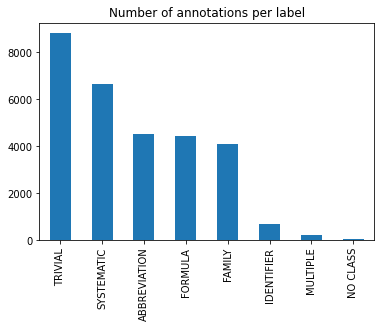

In [ ]:
train_data['Entity'].value_counts().plot(kind='bar', title='Number of annotations per label')

We have eight entities and the entity named `TRIVIAL` has the most number of annotations

Now we can start generating the annotation from the dataframe, to accomodate the training format that we want we can split the data frame to Title and Abstract annotations, so that we can run the same logic easily, (ie) grouping the texts and getting all the annotations corresponding to that text in one shot.

In [ ]:
abstract_annots = train_data.loc[train_data['Text Type'] == 'A', :]
title_annots = train_data.loc[train_data['Text Type'] == 'T', :]

In [ ]:
import en_core_sci_lg
from spacy.tokens import Span
from spacy.gold import docs_to_json
import json
# load the pretrained model and other utility functions
# to generate the training data
mod = en_core_sci_lg.load()
# since we are going to fill this manually
# for annotation, disabling some pipeline 
# modules may speedup the process
mod.disable_pipes(['ner'])

[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f8f0be55408>)]

In [ ]:
def extract_spacy_docs(annot_df:pd.DataFrame, ext_from:str) -> list:
    # Extracting the doc objects from a pretrained model
    # so that the tokenization matches for this domain of 
    # text that we have

    annot_docs = []
    # Same texts have multiple annotations so group and take 
    # one by one
    for _, annot_data in annot_df.groupby(ext_from):
        # Text for annotation
        txt = annot_data.iloc[0][ext_from]
        doc = mod(txt)
        ent_spans = []
        text_ranges = []
        for annot in annot_data.itertuples():
            start = int(annot.Start)
            end = int(annot.End)
            # Validating overlapping entity annotations
            if start not in text_ranges and end not in text_ranges:
                # Make spans with our annotations
                span = doc.char_span(int(annot.Start), int(annot.End), label=annot.Entity)

                # It may be None for invalid annotations(wrt spaCy)
                if span is not None:
                    ent_spans.append(span)
                    text_ranges.extend(list(range(start, end+1,)))

            # Just for info
            else:
                print(txt, txt[start:end])

        doc.ents = ent_spans
        annot_docs.append(doc)
    return annot_docs

In [ ]:
# generate docs for training
abstract_annots = extract_spacy_docs(abstract_annots, 'Abstract')
title_annots = extract_spacy_docs(title_annots, 'Title')

train_annot_docs = abstract_annots + title_annots

train_json = docs_to_json(train_annot_docs)

In [ ]:
# Persist data
spacy_annot_path = export_path/'annots'
spacy_annot_path.mkdir(exist_ok=True)

srsly.write_json(spacy_annot_path/'train_data.json', [train_json])

We must do the same for the development and evaluation data

## Make json file for evaluation and development

Let's make a function out of the process we did for the training data, for the evaluation and development data.

In [ ]:
dev_annots = pd.read_csv(annot_path/'development.annotations.txt', sep='\t',
                         names=['PMID', 'Text Type', 'Start', 'End', 'Entity Text', 'Entity'])

eval_annots = pd.read_csv(annot_path/'evaluation.annotations.txt', sep='\t',
                         names=['PMID', 'Text Type', 'Start', 'End', 'Entity Text', 'Entity'])

In [ ]:
def prepare_df_for_spacy_annots(df1: pd.DataFrame, df2: pd.DataFrame) -> 'Abstract and Title dataframes':
    # Emulates the processing we did for training data
    df1.set_index('PMID', drop=True, inplace=True)
    df2.set_index('PMID', drop=True, inplace=True)

    df = df1.join(df2)
    abstract_annots = df.loc[df['Text Type'] == 'A', :]
    title_annots = df.loc[df['Text Type'] == 'T', :]

    return abstract_annots, title_annots


def prepare_spacy_json_from_df(df1: pd.DataFrame, df2: pd.DataFrame):
    # transform the docs to spacy json    
    abstract_annots, title_annots = prepare_df_for_spacy_annots(df1, df2)
    
    abstract_docs = extract_spacy_docs(abstract_annots, 'Abstract')
    title_docs = extract_spacy_docs(title_annots, 'Title')

    annot_docs = abstract_docs + title_docs

    spacy_json = docs_to_json(train_annot_docs)
    return spacy_json

In [ ]:
# This might take some time
dev_json = prepare_spacy_json_from_df(dev_text, dev_annots)
eval_json = prepare_spacy_json_from_df(eval_text, eval_annots)

srsly.write_json(spacy_annot_path/'eval_data.json', [eval_json])
srsly.write_json(spacy_annot_path/'dev_data.json', [dev_json])

We now have all the files required to make the model, let's start by pretraining the model with spacy cli

## Pretrain spacy with texts

We have imported `scispacy's` model vectors(`en_core_sci_lg`) to give us a headstart

In [ ]:
!python -m spacy pretrain /content/data/spacy_annotation_data/texts/pretrain_txts.jsonl /usr/local/lib/python3.6/dist-packages/en_core_sci_lg/en_core_sci_lg-0.3.0 /content/data/pretrained_model -i 50 -se 10 -s 0 -bs 64

## Debug the training data for spacy NER model

Let's see if the data is proper for training using spacy's `debug-data` command

In [ ]:
%%bash
python -m spacy debug-data en\
    /content/drive/MyDrive/chemdNER\ data/annot_data/train_data.json \
    /content/drive/MyDrive/chemdNER\ data/annot_data/dev_data.json \
    -p 'ner' \
    -b /usr/local/lib/python3.6/dist-packages/en_core_sci_lg/en_core_sci_lg-0.3.0


=========================== Data format validation ===========================
✔ Corpus is loadable

=============================== Training stats ===============================
Training pipeline: ner
Starting with base model
'/usr/local/lib/python3.6/dist-packages/en_core_sci_lg/en_core_sci_lg-0.3.0'
4884 training docs
4884 evaluation docs
⚠ 4884 training examples also in evaluation data

============================== Vocab & Vectors ==============================
ℹ 647737 total words in the data (47733 unique)
ℹ 600000 vectors (667864 unique keys, 200 dimensions)
⚠ 21625 words in training data without vectors (0.03%)

========================== Named Entity Recognition ==========================
ℹ 8 new labels, 0 existing labels
0 missing values (tokens with '-' label)
⚠ 3 entity span(s) with punctuation
⚠ Low number of examples for new label 'NO CLASS' (40)
✔ Examples without occurrences available for all labels
✔ No entities consisting of or starting/ending with whitespace
Enti

We have low annotations for `NO CLASS` but since we do not have more data, we have to work with what we've got.

We only had `4884` pieces of text from the dataset, and it seems to be used in all the places (train, dev, eval), but the annotation in each will differ.

In [ ]:
# linking for easy access
!python -m spacy link /usr/local/lib/python3.6/dist-packages/en_core_sci_lg/en_core_sci_lg-0.3.0 en_core_sci_lg

## Train model

I tried to train with the pretrained model which we made using raw text but it was not working and it seems most of the tutorials use it only text classification problems.

But anyway I start with the vectors of `scispacy's` pretrained `en_core_sci_lg` model for a headstart.

In [ ]:
%%bash

python -m spacy train \
    en \
    /content/data/NER\ model \
    /content/drive/MyDrive/chemdNER\ data/annot_data/train_data.json \
    /content/drive/MyDrive/chemdNER\ data/annot_data/dev_data.json \
    -v /usr/local/lib/python3.6/dist-packages/en_core_sci_lg/en_core_sci_lg-0.3.0 \
    -p "ner" \
    -n 30 \
    -g 0 \
    -V 0.1 \
    -cW 3 -cd 4 -cw 4 -cP 3

Training pipeline: ['ner']
Using GPU: 0
Starting with blank model 'en'
Loading vector from model
'/usr/local/lib/python3.6/dist-packages/en_core_sci_lg/en_core_sci_lg-0.3.0'
Counting training words (limit=0)

Itn  NER Loss   NER P   NER R   NER F   Token %  CPU WPS  GPU WPS
---  ---------  ------  ------  ------  -------  -------  -------
  1  48369.133  38.580  23.141  28.929   91.214    79243    91040
  2  37874.029  41.895  28.937  34.231   91.214    79243    93572
  3  35916.519  45.435  33.101  38.300   91.214    79243    88774
  4  34941.559  48.925  37.233  42.286   91.214    79243    90150
  5  33485.552  52.235  40.570  45.669   91.214    79243    88586
  6  32591.528  56.412  44.786  49.931   91.214    79243    85016
  7  31565.729  59.580  48.290  53.344   91.214    79243    87689
  8  30361.623  63.674  53.106  57.912   91.214    79243    83318
  9  29941.032  66.154  56.482  60.937   91.214    79243    82007
 10  28910.156  68.003  58.950  63.154   91.214    79243    81201

I did not try to tune the hyper parameters and relied on the defaults from the lib, but it has given decent results

## Evaluate model with test data

Let's evaluate with the evaluation data that we generated earlier

In [ ]:
%%bash
python -m spacy evaluate \
    /content/data/NER\ model/model-best \
    /content/drive/MyDrive/chemdNER\ data/annot_data/eval_data.json \
    -g 0 -dp /content/data/eval\ results -R


================================== Results ==================================

Time      8.66 s
Words     688898
Words/s   79533 
TOK       91.21 
POS       0.03  
UAS       3.88  
LAS       0.00  
NER P     79.80 
NER R     72.58 
NER F     76.02 
Textcat   0.00  

✔ Generated 25 parses as HTML
/content/data/eval results


/usr/local/lib/python3.6/dist-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


The results of some text are persisted and can be viewed in the archive.

# Misc

Here I tried to write code for simple annotation format, mostly for archival, can be skipped, if need be

In [ ]:
def extract_annot_data(annot_df: pd.DataFrame, ext_from: str) -> list:
    # groups text and generates the list of entities and
    # their spans in the text
    train_data = []
    for _, annot_data in annot_df.groupby(ext_from):
        ttext = annot_data.iloc[0][ext_from]
        entity_list = []
        # print(ttext)
        text_ranges = []

        for annot in annot_data.itertuples():
            start = int(annot.Start)
            end = int(annot.End)
            if start not in text_ranges and end not in text_ranges:
                text_ranges.extend(list(range(start, end+1,)))
                entity_list.append((annot.Start, annot.End, annot.Entity))

        train_data.append((ttext, {'entities':entity_list}))

    return train_data

In [ ]:
abst_annots = extract_annot_data(abstract_annots, 'Abstract')
title_annots = extract_annot_data(title_annots, 'Title')

In [ ]:
abst_annots[0]

('(-)-Carvone is a monoterpene ketone found in spearmint (Mentha spicata var. crispa) essential oil that is widely used as an odor and flavor additive. An intestinal antispasmodic effect was recently reported for (-)-carvone, and it has been shown to be more potent than its (+)-antipode. The mechanism of (-)-carvone action in the intestines has not been investigated. To gain a better understanding of the (-)-carvone antispasmodic effect, we investigated its pharmacological effects in the guinea pig ileum. Terminal portions of the ileum were mounted for isotonic contraction recordings. The effect of (-)-carvone was compared with that of the classical calcium channel blocker (CCB) verapamil. In isolated ileal smooth muscle, (-)-carvone did not produce direct contractile or relaxation responses and did not modify electrically elicited contractions or low K(+)-evoked contractions. The submaximal contractions induced by histamine (p<0.001), BaCl2 (p<0.05), and carbachol (p<0.01) were signif

A sample text from the corpus

In [ ]:
ttext

'(-)-Carvone is a monoterpene ketone found in spearmint (Mentha spicata var. crispa) essential oil that is widely used as an odor and flavor additive. An intestinal antispasmodic effect was recently reported for (-)-carvone, and it has been shown to be more potent than its (+)-antipode. The mechanism of (-)-carvone action in the intestines has not been investigated. To gain a better understanding of the (-)-carvone antispasmodic effect, we investigated its pharmacological effects in the guinea pig ileum. Terminal portions of the ileum were mounted for isotonic contraction recordings. The effect of (-)-carvone was compared with that of the classical calcium channel blocker (CCB) verapamil. In isolated ileal smooth muscle, (-)-carvone did not produce direct contractile or relaxation responses and did not modify electrically elicited contractions or low K(+)-evoked contractions. The submaximal contractions induced by histamine (p<0.001), BaCl2 (p<0.05), and carbachol (p<0.01) were signifi

In [ ]:
from spacy.gold import docs_to_json, GoldParse

A sample of the spacy json format for training models

In [ ]:
#collapse-output
docs_to_json([mod(ttext)])

{'id': 0,
 'paragraphs': [{'cats': [],
   'raw': '(-)-Carvone is a monoterpene ketone found in spearmint (Mentha spicata var. crispa) essential oil that is widely used as an odor and flavor additive. An intestinal antispasmodic effect was recently reported for (-)-carvone, and it has been shown to be more potent than its (+)-antipode. The mechanism of (-)-carvone action in the intestines has not been investigated. To gain a better understanding of the (-)-carvone antispasmodic effect, we investigated its pharmacological effects in the guinea pig ileum. Terminal portions of the ileum were mounted for isotonic contraction recordings. The effect of (-)-carvone was compared with that of the classical calcium channel blocker (CCB) verapamil. In isolated ileal smooth muscle, (-)-carvone did not produce direct contractile or relaxation responses and did not modify electrically elicited contractions or low K(+)-evoked contractions. The submaximal contractions induced by histamine (p<0.001), Ba